# HW5-2. Decision Tree

## < Contents >  
 > 1. NO partitioning 
 > 2. Partitioning train/test 
 > 3. CV
 
 
## 0. Preprocessing 

In [1]:
# install.packages("rpart")    # decision tree library 
library(neuralnet) 
library(dummy) 
library(rpart)
library(ROCR)

# preprocessing 
bank = read.csv("bank-default2.csv",header=T)
bank$y = ifelse(bank$y == " yes", 1, 0)     # yes = 1, no = 0
bank$y = factor(bank$y)  

print(sum(is.na(bank)))            # 총 11개의 결측치가 존재 
bank = na.omit(bank)  

y = bank[, 17]    # 정기예금 가입 여부
X = bank[, c(1,6, 10, 12, 13, 14, 15 )]   

X['y'] = y
head(X, 3)

Warning message:
"package 'neuralnet' was built under R version 3.6.3"dummy 0.1.3
dummyNews()
Warning message:
"package 'ROCR' was built under R version 3.6.3"
Attaching package: 'ROCR'

The following object is masked from 'package:neuralnet':

    prediction



[1] 11


age,balance,day,duration,campaign,pdays,previous,y
58,2143,5,261,1,-1,0,0
44,29,5,151,1,-1,0,0
33,2,5,76,1,-1,0,0


## 1. NO partitioning 


#### 1) Control parameter 사용X : 복잡도 제어 X
fit = rpart(y ~., data=bank, method="class") 와 같은 단순 트리 fitting 사용 

#### 2) Control parameter 사용O : 복잡도 제어 O 
fit2 = rpart(y ~., data=bank, method="class", 
             control = rpart.control(xval=10, cp=0)) 와 같은 control 매개변수를 사용함 
> cp는 0에서 1사이의 값을 갖는데 이때 cp=0일수록 복잡한 트리를 뜻함. 

#### 3) Pruning the tree

앞선 depth가 깊고 복잡했던 tree를 가지치기해 depth를 조절

#### 4) Prediction 

앞선 pruning을 거친 DT로 model evaluation을 진행 

-----
#### 1) Control parameter 사용X : 복잡도 제어 X

In [37]:
# model fit 
set.seed(1)
fit = rpart(y ~., data=bank, method="class")

In [38]:
fit             # results 

n= 45200 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 45200 5287 0 (0.88303097 0.11696903)  
   2) duration< 521.5 40229 3106 0 (0.92279202 0.07720798)  
     4) poutcome= failure, other, unknown 38932 2301 0 (0.94089695 0.05910305) *
     5) poutcome= success 1297  492 1 (0.37933693 0.62066307)  
      10) duration< 162.5 360  113 0 (0.68611111 0.31388889) *
      11) duration>=162.5 937  245 1 (0.26147279 0.73852721) *
   3) duration>=521.5 4971 2181 0 (0.56125528 0.43874472)  
     6) duration< 827.5 3191 1147 0 (0.64055155 0.35944845)  
      12) poutcome= failure, other, unknown 3047 1030 0 (0.66196259 0.33803741) *
      13) poutcome= success 144   27 1 (0.18750000 0.81250000) *
     7) duration>=827.5 1780  746 1 (0.41910112 0.58089888) *

> 45200건의 total data 중 5287개의 오분류가 일어났음을 알 수 있습니다. 2)의 경우 duration이 521.5보다 작으면 대표그룹 0으로 분류하였으며, 이때 오분류 개체 개수는 3106개임을 알 수 있습니다. 거의 대부분의 node가 duration으로 split 되고 있는 것으로 보아 duration이 중요한 변수임을 알 수 있습니다. 

In [39]:
summary(fit)

Call:
rpart(formula = y ~ ., data = bank, method = "class")
  n= 45200 

          CP nsplit rel error    xerror       xstd
1 0.03789168      0 1.0000000 1.0000000 0.01292359
2 0.02534519      3 0.8863249 0.9042936 0.01236726
3 0.01702289      4 0.8609798 0.8696803 0.01215569
4 0.01000000      5 0.8439569 0.8549272 0.01206372

Variable importance
duration poutcome 
      61       38 

Node number 1: 45200 observations,    complexity param=0.03789168
  predicted class=0  expected loss=0.116969  P(node) =1
    class counts: 39913  5287
   probabilities: 0.883 0.117 
  left son=2 (40229 obs) right son=3 (4971 obs)
  Primary splits:
      duration < 521.5   to the left,   improve=1156.5900, (0 missing)
      poutcome splits as  LLRL,         improve= 879.1816, (0 missing)
      month    splits as  LLRLLLLRLLRR, improve= 518.2450, (0 missing)
      pdays    < 8.5     to the left,   improve= 265.5825, (0 missing)
      previous < 0.5     to the left,   improve= 261.4074, (0 missing)

Node nu

> DT fitting 결과 variable importance가 가장 높은 변수는 duration 입니다. 따라서 duration 변수를 활용해 tree는 가장 먼저 node를 형성하였고, duration이 521.5 이하, pdeays가 8.5 이하, previous가 0.5 이하이면 첫번째 노드에서는 left로 분류했음을 확인할 수 있습니다. 가장 imporvement가 높았던 변수 역시 duration 입니다. 

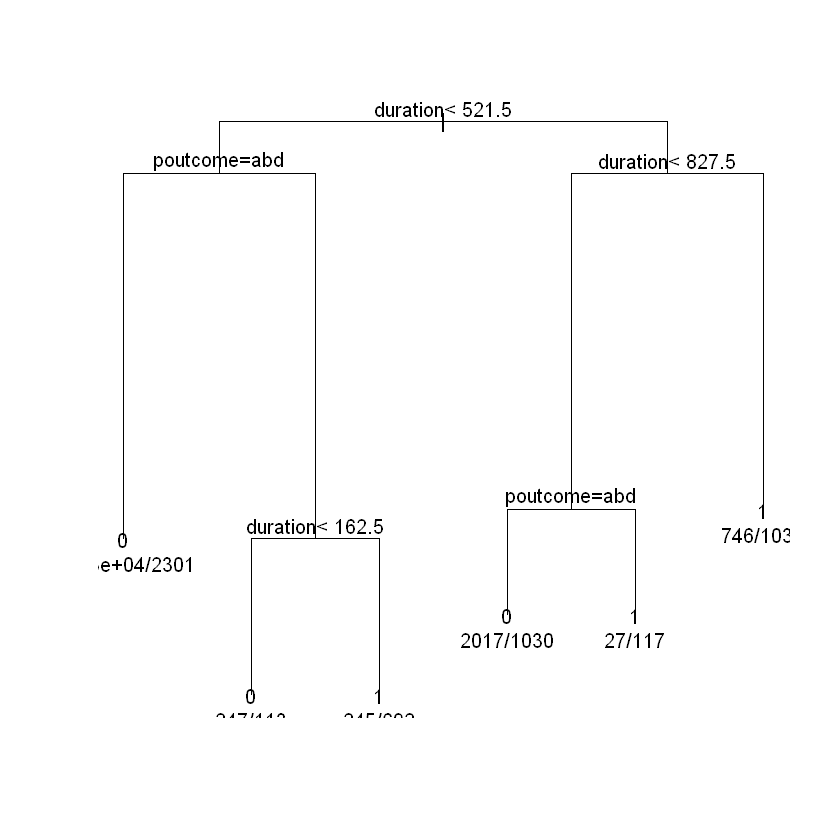

In [41]:
plot(fit);text(fit, use.n=TRUE)

> Tree plot은 다음과 같습니다. 균형잡힌 노드를 형성했음을 알 수 있습니다. 

#### 2) Control parameter 사용O : 복잡도 제어 O

cp = 0으로 설정해 앞선 fitting 보다 depth에 규제를 두지 않고 복잡한 트리를 생성

In [6]:
fit2 = rpart(y ~., data=bank, method="class", 
             control = rpart.control(xval=10, cp=0)) #cp=0 (maximal tree)

In [7]:
fit2

n= 45200 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

      1) root 45200 5287 0 (0.883030973 0.116969027)  
        2) duration< 521.5 40229 3106 0 (0.922792016 0.077207984)  
          4) poutcome= failure, other, unknown 38932 2301 0 (0.940896949 0.059103051)  
            8) month= apr, aug, feb, jan, jul, jun, may, nov 37479 1747 0 (0.953387230 0.046612770)  
             16) duration< 313.5 31469  979 0 (0.968890019 0.031109981)  
               32) age< 60.5 31039  870 0 (0.971970746 0.028029254)  
                 64) month= aug, jan, jul, jun, may, nov 27407  549 0 (0.979968621 0.020031379)  
                  128) pdays< 383.5 27323  518 0 (0.981041613 0.018958387)  
                    256) duration< 159.5 16593  114 0 (0.993129633 0.006870367)  
                      512) age>=22.5 16501  106 0 (0.993576147 0.006423853)  
                       1024) day>=4.5 15583   82 0 (0.994737855 0.005262145) *
                       1025) day< 4.5 918   24 0 (

> fitting 결과 앞선 fitting 결과 보다 노드의 개수가 훨씬 많으며, 복잡한 트리가 생성되었음을 알 수 있습니다. 

In [8]:
summary(fit2)

Call:
rpart(formula = y ~ ., data = bank, method = "class", control = rpart.control(xval = 10, 
    cp = 0))
  n= 45200 

             CP nsplit rel error    xerror       xstd
1  3.789168e-02      0 1.0000000 1.0000000 0.01292359
2  2.534519e-02      3 0.8863249 0.8978627 0.01232839
3  1.702289e-02      4 0.8609798 0.8657083 0.01213104
4  8.038585e-03      5 0.8439569 0.8528466 0.01205066
5  4.224198e-03      7 0.8278797 0.8403632 0.01197184
6  3.972007e-03     10 0.8152071 0.8392283 0.01196463
7  3.404577e-03     13 0.8032911 0.8362020 0.01194538
8  2.238194e-03     15 0.7964819 0.8214488 0.01185085
9  1.954480e-03     21 0.7830528 0.8153963 0.01181174
10 1.796860e-03     24 0.7771893 0.8144505 0.01180561
11 1.607717e-03     26 0.7735956 0.8138831 0.01180193
12 1.513145e-03     30 0.7671647 0.8106677 0.01178104
13 1.418574e-03     32 0.7641385 0.8093437 0.01177242
14 1.324002e-03     40 0.7512767 0.8091545 0.01177119
15 1.229431e-03     44 0.7459807 0.8093437 0.01177242
16 1.134859e-0

> 앞선 결과와 비슷하게 variable importance는 duration 변수가 가장 높습니다. 그 이후로 가장 중요했던 변수는 month, poutcome, job, age 등이 있습니다. 역시 duration 변수가 가장 노드 imporvement가 높습니다. 

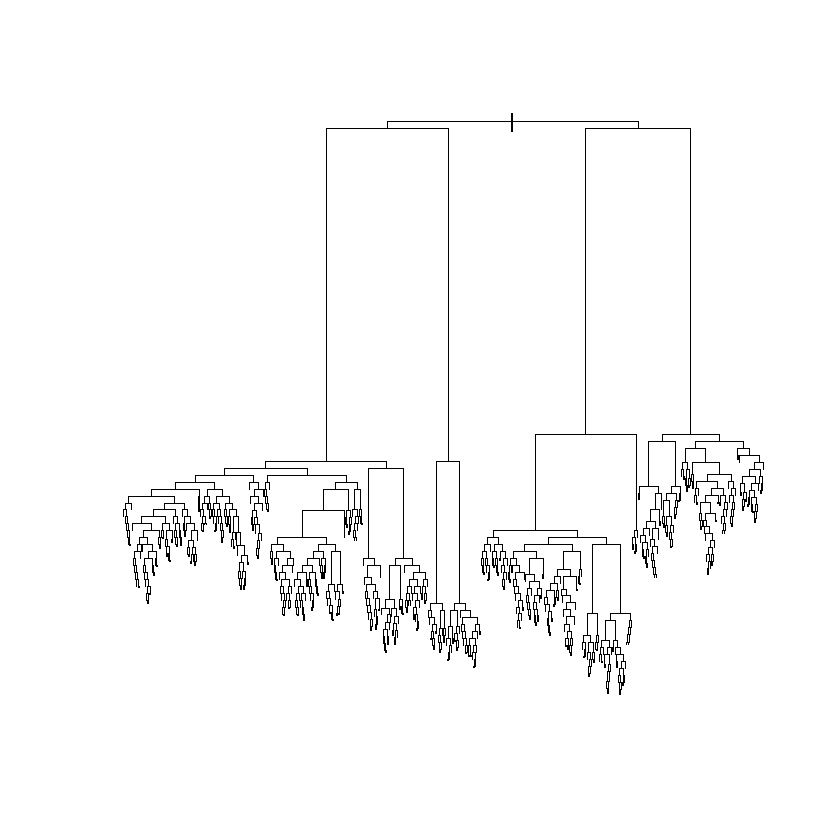

In [33]:
plot(fit2)

#### 3) Pruning the tree

앞선 depth가 깊고 복잡했던 tree를 가지치기해 depth를 조절 (tmp로 모델의 결과를 출력한 후, xerror가 가장 작았을 때의 cp 값으로 복잡도를 조절하는 방식)

- 단순히 작은 xerror의 cp로 복잡도를 설정하는 방식 

In [29]:
# tmp로 모델의 결과를 출력

tmp = printcp(fit2)
head(tmp, 3)

CP,nsplit,rel error,xerror,xstd
0.03789168,0,1.0000000,1.0000000,0.01292359
0.02534519,3,0.8863249,0.8978627,0.01232839
0.01702289,4,0.8609798,0.8657083,0.01213104


In [31]:
k = which.min(tmp[,"xerror"])      # 가장 작은 xerror를 출력함 
cp.tmp = tmp[k,"CP"]
cp.tmp                          

[1] 0.001008764

> tmp로 모델의 결과를 출력한 후, xerror가 가장 작았을 때의 cp 값은 0.001입니다. 따라서 pruning 시 cp값을 0.001로 조절합니다. 

In [10]:
fit.pruned = prune(fit2, cp=cp.tmp)      # cp = 0.001로 설정 


Classification tree:
rpart(formula = y ~ ., data = bank, method = "class", control = rpart.control(xval = 10, 
    cp = 0))

Variables actually used in tree construction:
 [1] age       balance   campaign  contact   day       default   duration 
 [8] education housing   job       loan      marital   month     pdays    
[15] poutcome  previous 

Root node error: 5287/45200 = 0.11697

n= 45200 

           CP nsplit rel error  xerror     xstd
1  3.7892e-02      0   1.00000 1.00000 0.012924
2  2.5345e-02      3   0.88632 0.89786 0.012328
3  1.7023e-02      4   0.86098 0.86571 0.012131
4  8.0386e-03      5   0.84396 0.85285 0.012051
5  4.2242e-03      7   0.82788 0.84036 0.011972
6  3.9720e-03     10   0.81521 0.83923 0.011965
7  3.4046e-03     13   0.80329 0.83620 0.011945
8  2.2382e-03     15   0.79648 0.82145 0.011851
9  1.9545e-03     21   0.78305 0.81540 0.011812
10 1.7969e-03     24   0.77719 0.81445 0.011806
11 1.6077e-03     26   0.77360 0.81388 0.011802
12 1.5131e-03     30   0.7

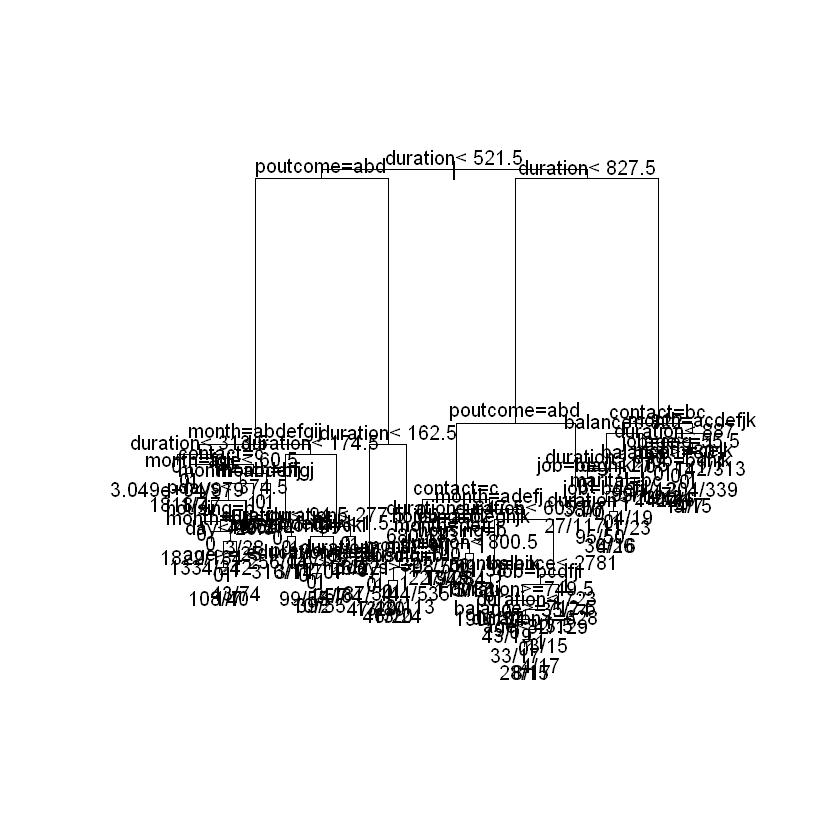

In [11]:
plot(fit.pruned, margin = 0.1);text(fit.pruned, use.n=TRUE)

> 앞선 트리보다 가지치기된 모습을 확인할 수 있습니다. 하지만 duration 변수가 첫 노드가 되어 split 되는건 앞선 트리들과 유사합니다. 



----
- 단순히 가장 작은 xerror를 선택하는 것이 아니라 xstd까지 고려해 cp를 선택하는 방식

In [12]:
tmp = printcp(fit2)
k = which.min(tmp[,"xerror"])
err = tmp[k,"xerror"]
se = tmp[k,"xstd"]

k = which(tmp[,"xerror"] <= err+se)[1]
cp.tmp = tmp[k,"CP"]
fit.pruned = prune(fit2, cp=cp.tmp)


Classification tree:
rpart(formula = y ~ ., data = bank, method = "class", control = rpart.control(xval = 10, 
    cp = 0))

Variables actually used in tree construction:
 [1] age       balance   campaign  contact   day       default   duration 
 [8] education housing   job       loan      marital   month     pdays    
[15] poutcome  previous 

Root node error: 5287/45200 = 0.11697

n= 45200 

           CP nsplit rel error  xerror     xstd
1  3.7892e-02      0   1.00000 1.00000 0.012924
2  2.5345e-02      3   0.88632 0.89786 0.012328
3  1.7023e-02      4   0.86098 0.86571 0.012131
4  8.0386e-03      5   0.84396 0.85285 0.012051
5  4.2242e-03      7   0.82788 0.84036 0.011972
6  3.9720e-03     10   0.81521 0.83923 0.011965
7  3.4046e-03     13   0.80329 0.83620 0.011945
8  2.2382e-03     15   0.79648 0.82145 0.011851
9  1.9545e-03     21   0.78305 0.81540 0.011812
10 1.7969e-03     24   0.77719 0.81445 0.011806
11 1.6077e-03     26   0.77360 0.81388 0.011802
12 1.5131e-03     30   0.7

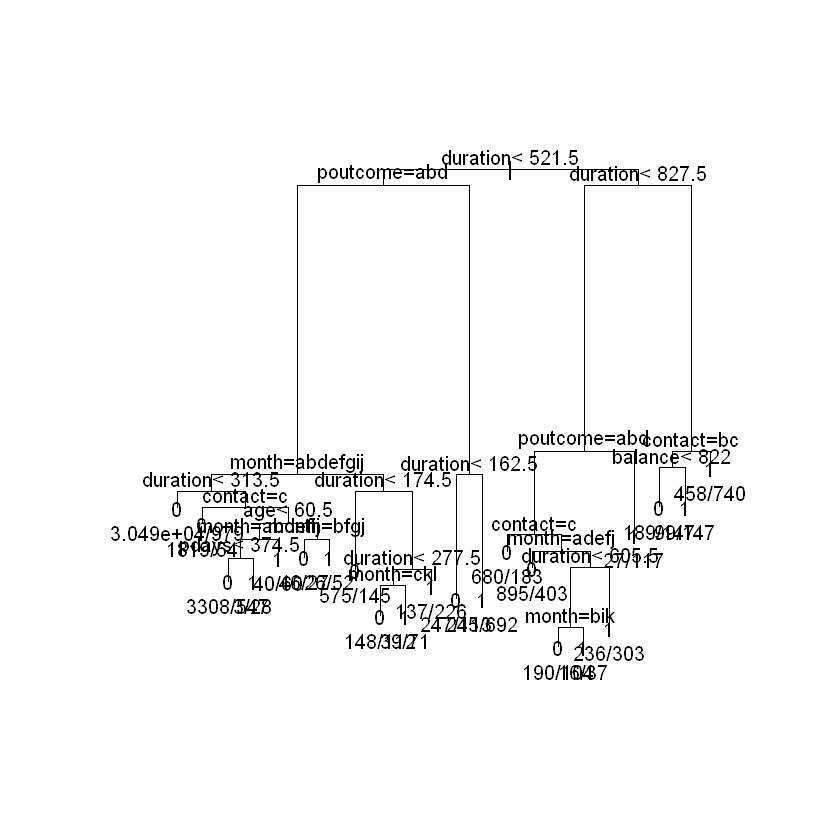

In [13]:
plot(fit.pruned, margin = 0.1);text(fit.pruned, use.n=TRUE)

> 단순히 가장 작은 xerror를 선택하는 것이 아니라 xstd까지 고려해 cp를 선택한 결과 앞선 결과보다 더 가지치기의 효과가 가시적임을 알 수 있습니다. 

#### 4) Prediction 

앞선 pruning을 거친 DT로 model evaluation을 진행 

In [14]:
cutoff = 0.5
pred = predict(fit.pruned, newdata=bank, type="prob") #prediction
yhat = ifelse(pred[,2] > cutoff, 1, 0)
ctable = table(bank$y, yhat, dnn=c("Actual", "Predicted")); ctable #classification table

      Predicted
Actual     0     1
     0 38587  1326
     1  2814  2473

> 실제로 정기예금에 가입하지 않았는데 가입했다고 예측한 오분류보다, 가입했는데 가입하지 않았다고 예측한 오분류가 약 2배 더 많습니다. 이는 bank data의 특성을 고려했을 때 앞선 KNN, LDA, QDA 등의 모델에서도 나타났던 오분류 양상과 유사합니다. 하지만 KNN, LDA, QDA는 동일한 오분류 양상이 약 3배정도 많았지만, DT는 약 2배정도로 DT가 이러한 오분류에 더 잘 대응하는 모델임을 알 수 있습니다. 

In [15]:
miss.err = 1-sum(diag(ctable))/sum(ctable); miss.err # Misclassification Rate
pred.acc = 1 - miss.err; pred.acc #Prediction Accuracy
diag(ctable)[2]/apply(ctable, 1, sum)[2] # Sensitivity
diag(ctable)[1]/apply(ctable, 1, sum)[1] # Specificity

[1] 0.09159292

[1] 0.9084071

1 
0.4677511

0 
0.9667777

> 민감도, 특이도 산출 결과 앞선 LDA, QDA 모델의 민감도인 약 0.29보다 DT의 민감도가 0.46으로 높습니다. DT의 특정 기준을 통해 node를 split 하는 모델 특성상, imbalanced data에 더 잘 대응하고 있음을 알 수 있습니다. 특이도와 prediction accuracy, Misclassification rate 또한 다른 앞선 모델들보다 가장 좋은 성능을 보이고 있습니다. 

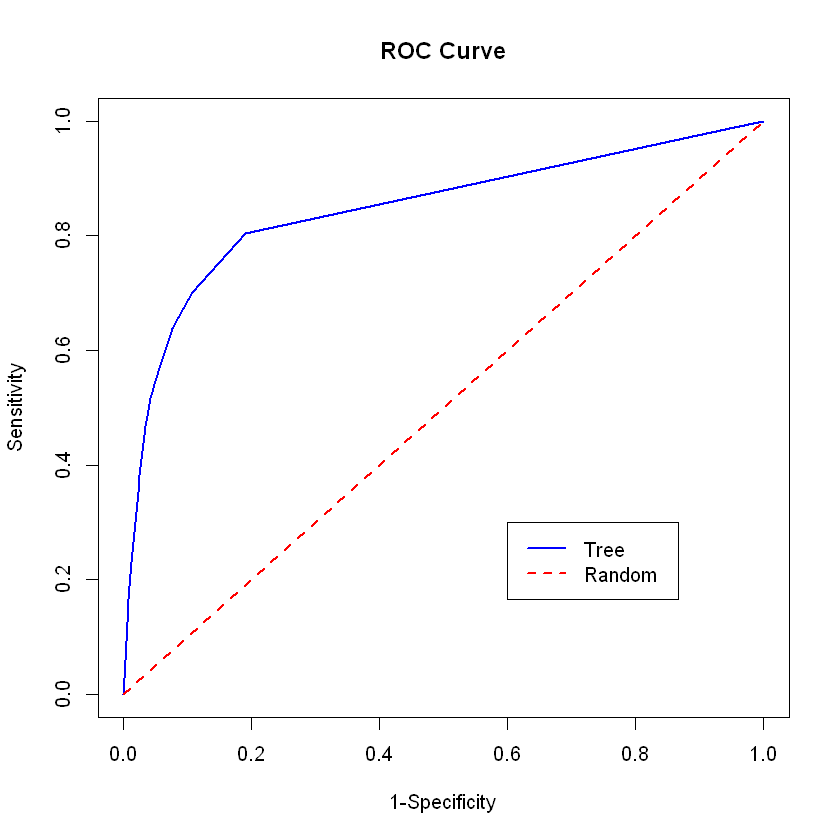

In [16]:
## ROC & AUC plot 
pred2 = predict(fit.pruned, newdata=bank, type="prob") #prediction
pred = prediction(pred2[,2], bank$y)
perf = performance(pred, "tpr","fpr")

# plotting 
plot(perf, col = 4, lwd = 2, xlab = "1-Specificity", ylab = "Sensitivity", main = "ROC Curve") #ROC
lines(x = c(0,1), y = c(0,1), col = 2, lty = 2, lwd = 2)
legend(0.6, 0.3, legend = c("Tree","Random"), col = c(4,2), lty = c(1,2), lwd = 2)

> 또한 ROC, AUC curve를 미루어 봤을 때, random prediction 보다 훨씬 우수한 모델임을 알 수 있습니다. 

In [17]:
# AUC 
performance(pred, "auc")@y.values 

[[1]]
[1] 0.8474612

## 2. Partitioning train/test 

In [18]:
## partitioning ( 7:3 으로 train, valid data를 구성합니다 ) 

set.seed(12)
V = 2
n =  NROW(bank)
id = sample(1:V, n, prob = c(0.7,0.3), replace = T) # Partitioning 7:3
ii = which(id==1)
bank.train = bank[ii,]
bank.test  = bank[-ii,]

앞선 동일 조건에서 train data를 학습시키고, control을 통해 모델의 복잡도를 cp=0으로 최대로 만들어 학습합니다. 


In [19]:
## DT modeling
fit = rpart(y ~., data=bank.train, method="class", control = rpart.control(xval=10, cp=0))
summary(fit)

Call:
rpart(formula = y ~ ., data = bank.train, method = "class", control = rpart.control(xval = 10, 
    cp = 0))
  n= 31586 

             CP nsplit rel error    xerror       xstd
1  2.720905e-02      0 1.0000000 1.0000000 0.01541872
2  2.707435e-02      2 0.9455819 0.9612069 0.01515569
3  2.478448e-02      4 0.8914332 0.9256466 0.01490769
4  1.481681e-02      5 0.8666487 0.8785022 0.01456817
5  6.869612e-03      6 0.8518319 0.8634159 0.01445681
6  5.118534e-03      8 0.8380927 0.8464440 0.01432990
7  3.502155e-03     11 0.8178879 0.8389009 0.01427293
8  3.367457e-03     13 0.8108836 0.8345905 0.01424021
9  3.232759e-03     17 0.7968750 0.8345905 0.01424021
10 2.693966e-03     18 0.7936422 0.8321659 0.01422176
11 2.559267e-03     19 0.7909483 0.8316272 0.01421765
12 2.514368e-03     21 0.7858297 0.8321659 0.01422176
13 2.424569e-03     24 0.7782866 0.8313578 0.01421560
14 2.155172e-03     26 0.7734375 0.8281250 0.01419092
15 2.020474e-03     34 0.7545797 0.8240841 0.01415998
16 1.885

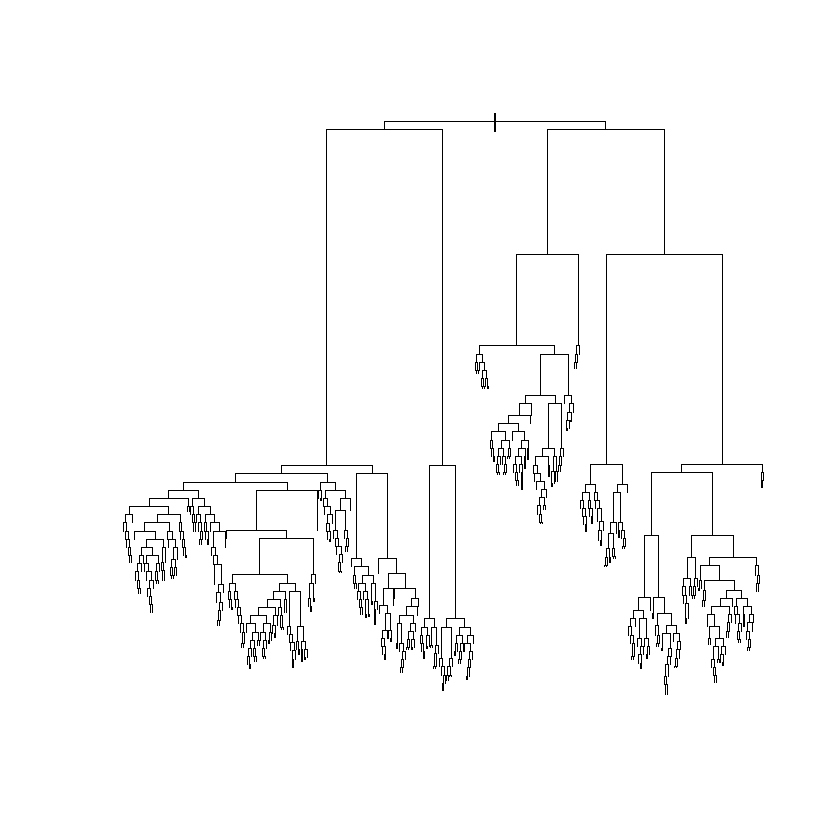

In [20]:
plot(fit)

> Train data로 모델을 학습한 결과, 앞선 No partition 분석과 유사한 트리가 완성되었습니다. 또한 복잡도(cp)를 최대로 설정했기 때문에, 깊고 복잡한 트리가 형성되었음을 알 수 있습니다. 


Classification tree:
rpart(formula = y ~ ., data = bank.train, method = "class", control = rpart.control(xval = 10, 
    cp = 0))

Variables actually used in tree construction:
 [1] age       balance   campaign  contact   day       duration  education
 [8] housing   job       loan      marital   month     pdays     poutcome 
[15] previous 

Root node error: 3712/31586 = 0.11752

n= 31586 

           CP nsplit rel error  xerror     xstd
1  2.7209e-02      0   1.00000 1.00000 0.015419
2  2.7074e-02      2   0.94558 0.96121 0.015156
3  2.4784e-02      4   0.89143 0.92565 0.014908
4  1.4817e-02      5   0.86665 0.87850 0.014568
5  6.8696e-03      6   0.85183 0.86342 0.014457
6  5.1185e-03      8   0.83809 0.84644 0.014330
7  3.5022e-03     11   0.81789 0.83890 0.014273
8  3.3675e-03     13   0.81088 0.83459 0.014240
9  3.2328e-03     17   0.79688 0.83459 0.014240
10 2.6940e-03     18   0.79364 0.83217 0.014222
11 2.5593e-03     19   0.79095 0.83163 0.014218
12 2.5144e-03     21   0.78583

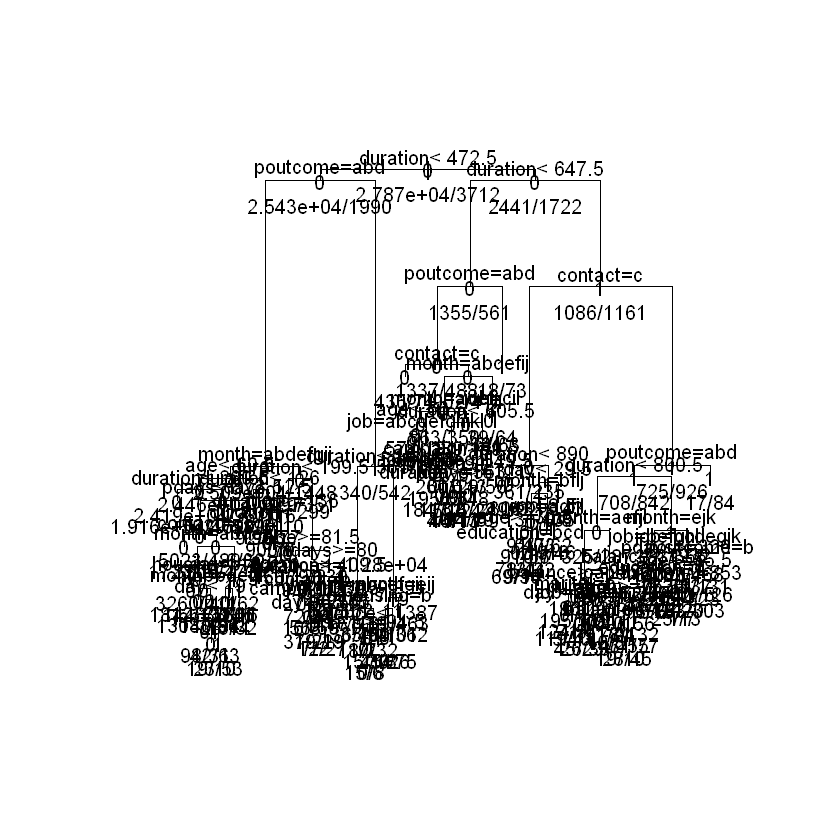

In [21]:
## Pruning : xerror를 고려해 가지치기를 진행합니다. 

tmp = printcp(fit)
k = which.min(tmp[,"xerror"])
cp.tmp = tmp[k,"CP"]
fit.pruned = prune(fit, cp=cp.tmp)
plot(fit.pruned, margin = 0.1);text(fit.pruned, use.n=TRUE, all = T)

In [22]:
## Predicting and Evaluating
cutoff = 0.5
pred = predict(fit.pruned, newdata=bank.test, type="prob") #prediction
yhat = ifelse(pred[,2] > cutoff, 1, 0)
ctable = table(bank.test$y, yhat, dnn=c("Actual", "Predicted")); ctable #classification table

miss.err = 1-sum(diag(ctable))/sum(ctable); miss.err # Misclassification Rate
pred.acc = 1 - miss.err; pred.acc #Prediction Accuracy
diag(ctable)[2]/apply(ctable, 1, sum)[2] # Sensitivity
diag(ctable)[1]/apply(ctable, 1, sum)[1] # Specificity

      Predicted
Actual     0     1
     0 11567   472
     1   850   725

[1] 0.09710592

[1] 0.9028941

1 
0.4603175

0 
0.9607941

> 민감도, 특이도 산출 결과 앞선 NO partition 분석과 유사한 지표가 산출되었습니다.역시 특이도와 prediction accuracy, Misclassification rate 또한 다른 앞선 모델들보다 가장 좋은 성능을 보이고 있습니다. 

[[1]]
[1] 0.8816525

[[1]]
[1] 0.8626446

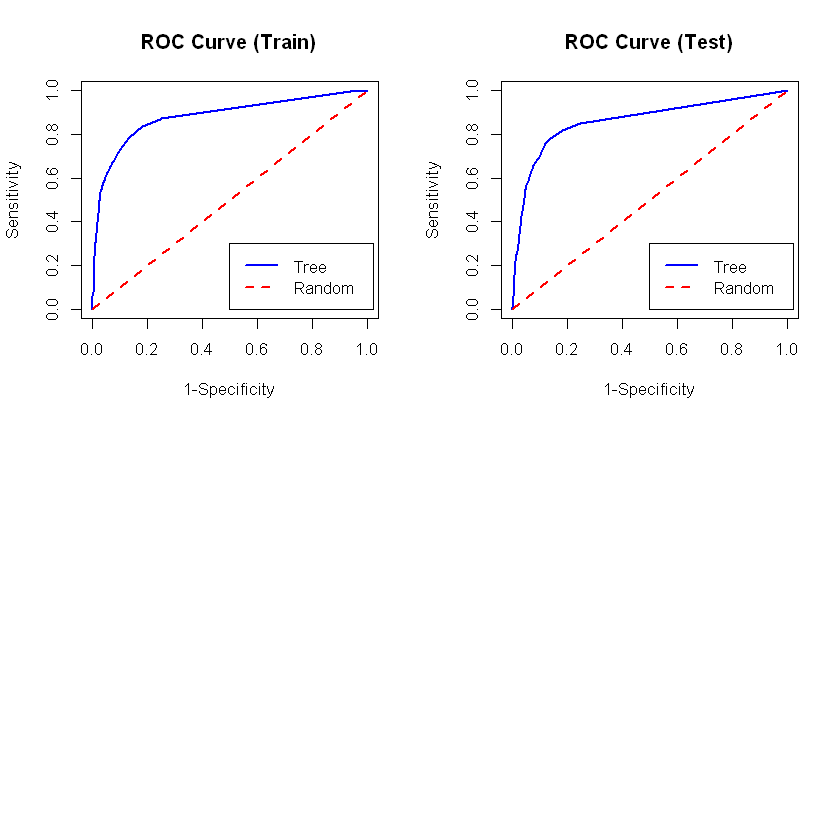

In [23]:
## ROC and AUC
par(mfrow = c(2,2))

## Plot 1) train evaluation 
pred2 = predict(fit.pruned, newdata=bank.train, type="prob") #prediction
pred = prediction(pred2[,2], bank.train$y)
perf = performance(pred, "tpr","fpr")

plot(perf, col = 4, lwd = 2, xlab = "1-Specificity", ylab = "Sensitivity", main = "ROC Curve (Train)") #ROC
lines(x = c(0,1), y = c(0,1), col = 2, lty = 2, lwd = 2)
legend(0.5, 0.3, legend = c("Tree","Random"), col = c(4,2), lty = c(1,2), lwd = 2)

performance(pred, "auc")@y.values #AUC

## Plot 2) test evaluation 
pred2 = predict(fit.pruned, newdata=bank.test, type="prob") #prediction
pred = prediction(pred2[,2], bank.test$y)
perf = performance(pred, "tpr","fpr")

plot(perf, col = 4, lwd = 2, xlab = "1-Specificity", ylab = "Sensitivity", main = "ROC Curve (Test)") #ROC
lines(x = c(0,1), y = c(0,1), col = 2, lty = 2, lwd = 2)
legend(0.5, 0.3, legend = c("Tree","Random"), col = c(4,2), lty = c(1,2), lwd = 2)

performance(pred, "auc")@y.values #AUC

> ROC curve를 통해 train과 test의 예측 양상을 파악한 결과, train AUC가 test AUC 보다 약 0.02정도 더 높습니다. 

## 3. CV error 

In [24]:
#V-fold CV
V = 10 
miss.err.train = 0
miss.err.test = 0
cutoff = 0.5

set.seed(123)
id = sample(1:V, nrow(bank), replace = T)

In [25]:
for(i in 1:V) {
  print(i)
  bank.train = bank[id != i,] 
  bank.test  = bank[id == i,] 
  fit = rpart(y ~., data=bank.train, method="class", 
              control = rpart.control(xval=10, cp=0)) #maximal tree
  
  tmp = printcp(fit)
  k = which.min(tmp[,"xerror"])
  cp.tmp = tmp[k,"CP"]
  fit.pruned = prune(fit, cp=cp.tmp) #tree with min CV error
  
  pred = predict(fit.pruned, newdata=bank.test, type="prob") #prediction for test data
  yhat = ifelse(pred[,2] > cutoff, 1, 0)
  miss.err.test = miss.err.test + mean(bank.test$y != yhat) 
  
}

cv.err.test = miss.err.test/V; cv.err.test

[1] 1

Classification tree:
rpart(formula = y ~ ., data = bank.train, method = "class", control = rpart.control(xval = 10, 
    cp = 0))

Variables actually used in tree construction:
 [1] age       balance   campaign  contact   day       duration  education
 [8] housing   job       loan      marital   month     pdays     poutcome 
[15] previous 

Root node error: 4795/40761 = 0.11764

n= 40761 

           CP nsplit rel error  xerror     xstd
1  3.6983e-02      0   1.00000 1.00000 0.013565
2  2.6694e-02      3   0.88905 0.91887 0.013074
3  1.7101e-02      4   0.86236 0.87383 0.012787
4  8.1335e-03      5   0.84526 0.85860 0.012688
5  4.4838e-03      7   0.82899 0.84943 0.012627
6  4.0320e-03      9   0.82002 0.83921 0.012559
7  2.7112e-03     13   0.80355 0.83149 0.012508
8  2.6069e-03     15   0.79812 0.83212 0.012512
9  2.5026e-03     17   0.79291 0.83149 0.012508
10 2.2941e-03     18   0.79041 0.83087 0.012504
11 2.1898e-03     20   0.78582 0.82941 0.012494
12 2.1550e-03     22   0

[1] 0.09606962

> Cross validation 형식으로 10개의 fold를 구성해 validation 한 결과 앞선 Missclassification rate와 비슷한 수치가 출력되었습니다. 